In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# User modifiable values

In [ ]:
# path to eeg and marker files respectively
eeg_data_filepath = "data/10-30-Haden-01/eeg.csv"
marker_data_filepath = "data/10-30-Haden-01/marker.csv"

# what target the participant was focusing on
# A = 1, B = 2, ...
target_marker = 1

# sampling rate of EEG headset
samplerate = 250.0

## Read data

In [3]:
# read data from files
raw_eeg_data = pd.read_csv(eeg_data_filepath)
raw_marker_data = pd.read_csv(marker_data_filepath)

# convert data to numpy arrays
eeg_data_numpy = raw_eeg_data.to_numpy(na_value=np.nan)
marker_data_numpy = raw_marker_data.to_numpy(na_value=np.nan)

# transpose the data
eeg_data = eeg_data_numpy.T
marker_data_numpy = marker_data_numpy.T

# get timestamps from both data sets
eeg_timestamps = eeg_data[0, :]
marker_timestamps = marker_data_numpy[0, :]
marker_data = marker_data_numpy[1, :]


## Filter data

In [4]:
# notch filter to remove powerline noise (60 Hz)
notch_frequency = 60
b, a = signal.iirnotch(notch_frequency, 20, samplerate)
eeg_data_notch_filter = signal.filtfilt(b, a, eeg_data[1:, :])

# bandpass filter to remove noise outside of 1-50 Hz
high_pass_frequency = 1
low_pass_frequency = 30
b, a =  signal.iirfilter(int(3), [high_pass_frequency, low_pass_frequency], btype="bandpass", ftype="butter", fs=samplerate, output="ba")
eeg_data_filtered = signal.filtfilt(b, a, eeg_data_notch_filter)


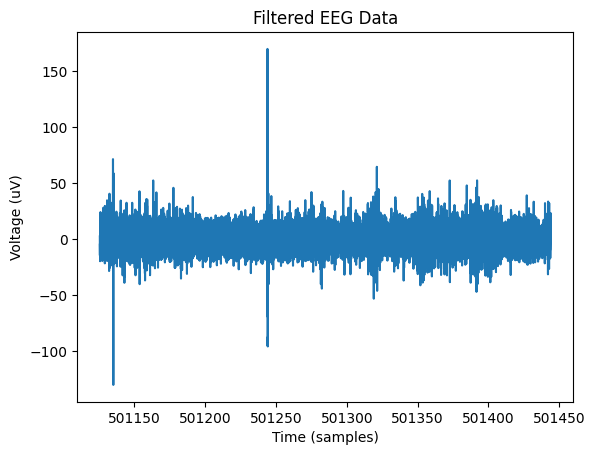

In [19]:
# plot the filtered data
plt.figure()
plt.plot(eeg_timestamps, eeg_data_filtered[0, :])
plt.title("Filtered EEG Data")
plt.xlabel("Time (samples)")
plt.ylabel("Voltage (uV)")
plt.show()

## Get goal timestamps

In [21]:
# helper function
def get_index_of_nearest_timestamp(goal_timestamp, timestamps):
    return np.argmin(np.abs(timestamps - goal_timestamp))

# get timestamps from when the target marker was shown
p300_timestamps = []
for i in range(len(marker_data)):
    if marker_data[i] == target_marker:
        p300_timestamps.append(marker_timestamps[i])

# get coordinating timestamps from the EEG data
p300_eeg_timestamps = []
for timestamp in p300_timestamps:
    p300_eeg_timestamps.append(eeg_timestamps[get_index_of_nearest_timestamp(timestamp, eeg_timestamps)])

In [23]:
print(p300_eeg_timestamps[0])
print(p300_timestamps[0])

print(f"\n Number of P300 events: {len(p300_timestamps)}")

501444.08686217
1745217680.5990596

 Number of P300 events: 20
